In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy
from tqdm import tqdm
import seaborn as sns
pd.options.display.expand_frame_repr = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_close = pd.read_csv('../data_correct/Close_correct.csv', index_col='date')
data_close.index = data_close.index.astype('datetime64').rename('date')

data_open = pd.read_csv('../data_correct/Open_correct.csv', index_col='date')
data_open.index = data_open.index.astype('datetime64').rename('date')

data_low = pd.read_csv('../data_correct/Low_correct.csv', index_col='date')
data_low.index = data_low.index.astype('datetime64').rename('date')

data_high = pd.read_csv('../data_correct/High_correct.csv', index_col='date')
data_high.index = data_high.index.astype('datetime64').rename('date')

data_volume = pd.read_csv('../data/Volume.csv').T[1:]
data_volume.index = data_volume.index.astype('datetime64').rename('date')
data_volume = data_volume.astype('float64')

In [4]:
data_returns = pd.read_csv('../data/data_returns.csv', index_col='date')
data_returns.index = data_returns.index.astype('datetime64').rename('date')
data_returns = data_returns.fillna(0)

In [5]:
ts_rank_close_20 = pd.read_csv('ts_rank_volume_20.csv', index_col='date')
ts_rank_close_20.index = ts_rank_close_20.index.astype('datetime64')
ts_rank_close_20 = ts_rank_close_20.astype('float64')

ts_rank_volume_20 = pd.read_csv('ts_rank_volume_20.csv', index_col='date')
ts_rank_volume_20.index = ts_rank_volume_20.index.astype('datetime64')
ts_rank_volume_20 = ts_rank_volume_20.astype('float64')

ts_rank_returns_20 = pd.read_csv('ts_rank_returns_20.csv', index_col='date')
ts_rank_returns_20.index = ts_rank_returns_20.index.astype('datetime64')
ts_rank_returns_20 = ts_rank_returns_20.astype('float64')

In [6]:
crr_vol_cls = pd.read_csv('../task_list_2/corr_volume_close.csv', index_col='date')
crr_vol_cls.index = crr_vol_cls.index.astype('datetime64').rename('date')

In [7]:
def neutralize(alpha):
    return alpha - np.mean(alpha)


def normalize(alpha):
    return alpha / np.sum(np.abs(alpha))


def get_rank(alpha):
    return scipy.stats.rankdata(alpha, method='ordinal') / (len(alpha) - 1)


def cut_outliers(alpha, coef=0.01):
    alpha[alpha < np.quantile(alpha, coef)] = 0
    alpha[alpha > np.quantile(alpha, 1 - coef)] = 0
    return alpha


def cut_middle(alpha, coef=0.01):
    alpha[(alpha < np.quantile(alpha, 0.5 + coef)) & (alpha > np.quantile(alpha, 0.5 - coef))] = 0
    return alpha


def get_decay_vect(alpha, d, k):
    if d < k:
        return 'Error'
    temp = np.zeros(alpha.shape[1])
    for i in range(k):
        temp += ((k - i) / k) * alpha.iloc[d - i]
    return temp


def get_decay_alpha(alpha, d, k):
    alpha_new = alpha.copy().iloc[0 : d]
    for i in range(d, len(alpha)):
        alpha_new.loc[len(alpha_new.index)] = get_decay_vect(alpha, i, k)
    alpha_new.index = alpha.iloc[0:len(alpha_new.index)].index
    return alpha_new

### Metrics

In [8]:
def turnover(alphas, option=0):
    turnover_days = abs(alphas.diff(periods=1)).sum(axis=1)
    if option == 1:
        return turnover_days
    return turnover_days.groupby(alphas.index.year).mean()


def get_sharpe_coef(days_pnl):
    ans = pd.DataFrame()
    ans['coef_sharpe'] = days_pnl.groupby(days_pnl.index.year).apply(lambda x : np.sqrt(len(x) - 1) * np.mean(x) / np.std(x))
    return ans


def get_drawdown_t_2(pnl_cum):
    pnl_cum_index =  pnl_cum.index
    pnl_cum = np.array(pnl_cum)
    max_drawdown = -1
    for i in range(0, len(pnl_cum)):
        for j in range(i + 1, len(pnl_cum)):
            if ((pnl_cum[i] - pnl_cum[j]) > max_drawdown) and (pnl_cum[i] - pnl_cum[j]) > 0:
                if (pnl_cum[i] - pnl_cum[j]) != np.inf:
                    max_drawdown = (pnl_cum[i] - pnl_cum[j])
                    days_i = i
                    days_j = j
    return max_drawdown, pnl_cum_index[days_i].strftime("%d.%m.%Y"), pnl_cum_index[days_j].strftime("%d.%m.%Y")


def get_drawdown_years(pnl_cum):
    return pnl_cum.groupby(pnl_cum.index.year).apply(lambda x: get_drawdown_t_2(x))


def get_pnl(data_returns, alpha, option=0):
    data_returns = data_returns.iloc[2:]
    pnl = alpha.reset_index(drop=True).mul(data_returns.reset_index(drop=True), axis=0).sum(axis=1)
    ans = pd.DataFrame()
    ans['pnl'] = pnl
    ans = ans.set_index(alpha.index).shift(2)
    if option == 1:
        return ans.set_index(alpha.index).groupby(alpha.index.year).sum()
    return ans


def alpha_stats(data_returns, alpha):
    days_pnl = get_pnl(data_returns, alpha).fillna(0)['pnl']
    print(sum(days_pnl))
    returns_table = pd.DataFrame()
    returns_table['years_pnl_cum'] = get_pnl(data_returns, alpha, 1)
    returns_table['turnover'] = turnover(alpha)
    returns_table['sharpe_coef'] = get_sharpe_coef(days_pnl)
    returns_table['drawdown'] = get_drawdown_years(days_pnl.cumsum()).apply(lambda x: x[0])
    returns_table['drawdown_day_start'] = get_drawdown_years(days_pnl.cumsum()).apply(lambda x: x[1])
    returns_table['drawdown_day_end'] = get_drawdown_years(days_pnl.cumsum()).apply(lambda x: x[2])
    days_pnl.cumsum().plot()
    plt.grid()
    plt.show()
    return returns_table

Alpha rank
### $$ ts\_rank(data, k) $$

$$ ts\_rank(close, 20) $$

In [9]:
#def ts_rank(data, k):
#    ans = data.copy().iloc[:0]
#    for i in tqdm(range(len(data) - k)):
#        ans.loc[len(ans)] = data.iloc[i : k + i].apply(get_rank).iloc[-1]
#    return ans

In [10]:
#ts_rank_close_20 = ts_rank(data_close, 20)
#ts_rank_close_20.index = data_close.iloc[20:].index
#ts_rank_close_20.to_csv('ts_rank_close_20.csv')

#a = pd.DataFrame(np.zeros((20,2436)))
#a.index = data_close.iloc[:20].index
#a.columns = ts_rank_close_20.columns
#ts_rank_close_20 = a.append(ts_rank_close_20)
#ts_rank_close_20.to_csv('ts_rank_close_20.csv')

In [11]:
#ts_rank_volume_20 = ts_rank(data_volume, 20)
#ts_rank_volume_20.index = data_volume.iloc[20:].index

#a = pd.DataFrame(np.zeros((20,2436)))
#a.index = data_volume.iloc[:20].index
#a.columns = ts_rank_volume_20.columns
#ts_rank_volume_20 = a.append(ts_rank_volume_20)
#ts_rank_volume_20.to_csv('ts_rank_volume_20.csv')

In [12]:
#ts_rank_returns_20 = ts_rank(data_volume, 20)
#ts_rank_returns_20.index = data_volume.iloc[20:].index

#a = pd.DataFrame(np.zeros((20,2436)))
#a.index = data_returns.iloc[:20].index
#a.columns = ts_rank_returns_20.columns
#ts_rank_returns_20 = a.append(ts_rank_returns_20)
#ts_rank_returns_20.to_csv('ts_rank_returns_20.csv')

In [13]:
def algh_high_minus_low_over_close(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = (data_low - data_high)
    alpha = (data_close.shift(n) - data_open) / (kernel + 0.001)
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking ==True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return -alpha

0.5425696352175059


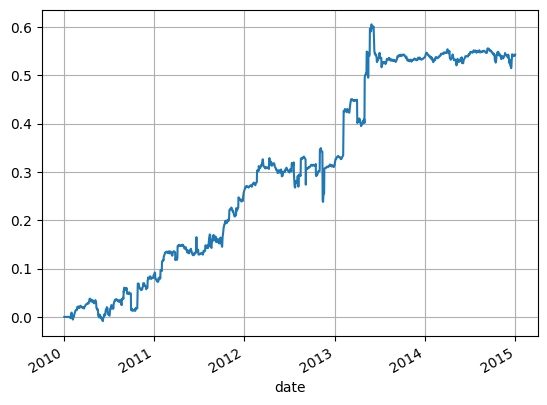

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.086569,0.669487,1.184552,0.047970,03.09.2010,18.10.2010
2011,0.170447,0.700705,2.018270,0.036225,22.06.2011,18.07.2011
2012,0.056604,0.701401,0.357856,0.111197,06.11.2012,14.11.2012
2013,0.223720,0.696128,1.308615,0.088689,30.05.2013,09.07.2013
2014,0.005230,0.602263,0.112871,0.041098,11.09.2014,15.12.2014


In [14]:
alpha_stats(data_returns, algh_high_minus_low_over_close(n=15, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False))

In [15]:
def algh_high_minus_low_over_close_ts_rank(n=1, ts_rank_data=0, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = (data_low - data_high)
    alpha = -ts_rank_data * ((data_close.shift(n) - data_open) / (kernel + 0.001))
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking ==True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

0.3966189234045001


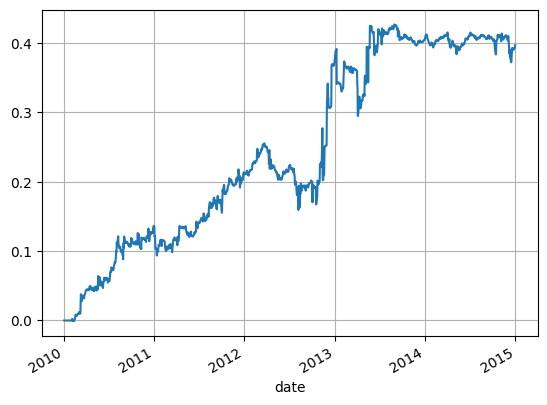

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.136211,0.295317,1.951579,0.033146,10.08.2010,30.08.2010
2011,0.077497,0.325607,1.171261,0.042273,03.01.2011,13.01.2011
2012,0.158533,0.312831,0.980875,0.095837,22.03.2012,07.08.2012
2013,0.032736,0.307476,0.237249,0.096398,08.01.2013,05.04.2013
2014,-0.008359,0.303266,-0.190166,0.043047,02.04.2014,15.12.2014


In [16]:
alpha_stats(data_returns, algh_high_minus_low_over_close_ts_rank(n=5, ts_rank_data=ts_rank_close_20, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0, ranking=False, decaying=True, decay_d=10, decay_k=10))

0.7111543742284457


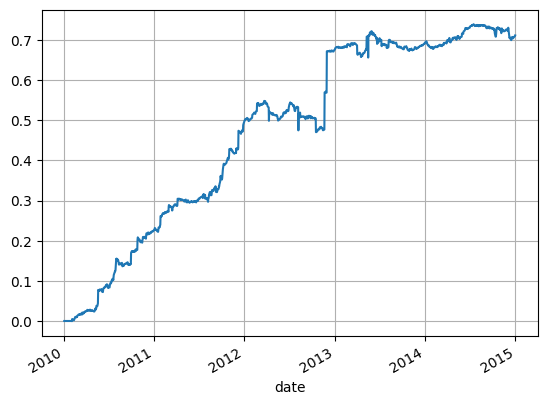

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.224693,0.955138,3.359980,0.018911,04.08.2010,27.08.2010
2011,0.267656,1.055936,3.723775,0.019324,21.07.2011,08.08.2011
2012,0.182973,1.031400,1.087052,0.077985,22.03.2012,18.10.2012
2013,0.015894,1.028904,0.168823,0.052162,13.05.2013,16.05.2013
2014,0.019938,0.975504,0.514055,0.039119,16.07.2014,15.12.2014


In [17]:
alpha_stats(data_returns, algh_high_minus_low_over_close_ts_rank(n=5, ts_rank_data=ts_rank_volume_20, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0, ranking=False, decaying=False))

0.7111543742284457


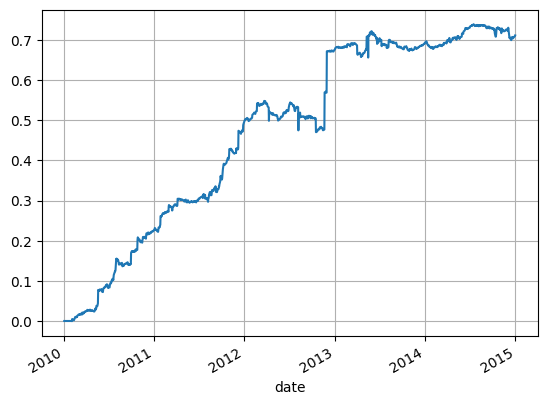

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.224693,0.955138,3.359980,0.018911,04.08.2010,27.08.2010
2011,0.267656,1.055936,3.723775,0.019324,21.07.2011,08.08.2011
2012,0.182973,1.031400,1.087052,0.077985,22.03.2012,18.10.2012
2013,0.015894,1.028904,0.168823,0.052162,13.05.2013,16.05.2013
2014,0.019938,0.975504,0.514055,0.039119,16.07.2014,15.12.2014


In [18]:
alpha_stats(data_returns, algh_high_minus_low_over_close_ts_rank(n=5, ts_rank_data=ts_rank_returns_20, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0, ranking=False, decaying=False))

In [19]:
def algh_ts_rank(ts_rank_data=0, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = ts_rank_data
    alpha = -kernel
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking ==True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

In [20]:
def algh_ts_rank_close(ts_rank_data_1=0, ts_rank_data_2=0, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = (ts_rank_data_1 / ts_rank_data_2) * (data_close / data_close.shift(5) - 1)
    alpha = -kernel
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking ==True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

In [21]:
def algh_alpha_high_plus_low_minus_two_close(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = (data_high + data_low - 2 * data_close).copy()
    alpha = kernel / data_close
    if decaying==True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking ==True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

0.6875175342474718


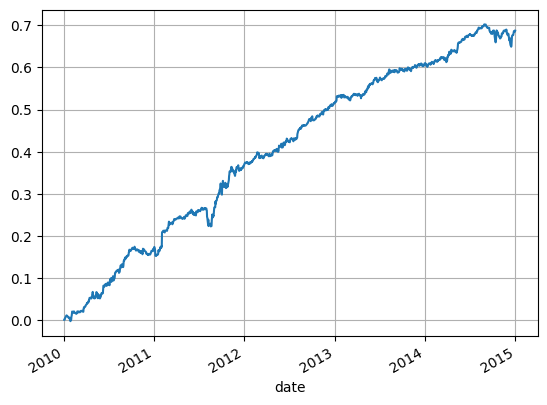

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.167315,0.902549,3.456106,0.019822,15.10.2010,10.12.2010
2011,0.198500,0.899981,2.550237,0.044218,13.07.2011,19.08.2011
2012,0.149061,0.883446,3.810478,0.014334,23.02.2012,19.03.2012
2013,0.095080,0.887939,2.633957,0.013249,06.02.2013,04.03.2013
2014,0.077561,0.902576,1.603889,0.053033,28.08.2014,15.12.2014


In [22]:
alpha_stats(data_returns, algh_alpha_high_plus_low_minus_two_close(data_close=data_close, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=True, decay_d=4, decay_k=3))

In [23]:
def algh_alpha_reversion(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = (data_close / data_close.shift(n) - 1)
    alpha = -kernel
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking == True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T

    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

0.5891173213561448


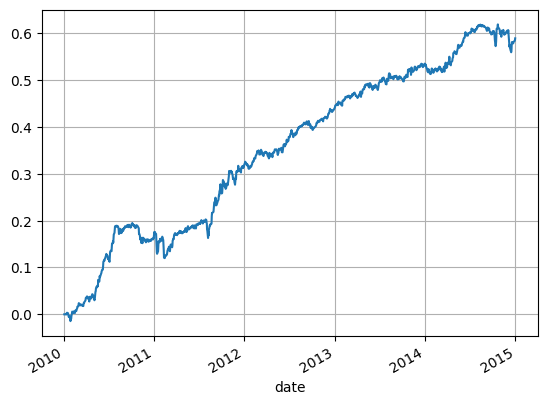

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.161662,0.626295,2.859316,0.042312,05.10.2010,16.11.2010
2011,0.154295,0.647937,1.913424,0.055726,03.01.2011,14.02.2011
2012,0.123747,0.639653,2.905585,0.019038,18.09.2012,04.10.2012
2013,0.093617,0.636498,2.039114,0.017237,09.08.2013,07.10.2013
2014,0.055797,0.633862,0.878671,0.059483,22.10.2014,15.12.2014


In [24]:
alpha_stats(data_returns, algh_alpha_reversion(n=5, data_close=data_close, cut_middle_coef=0, cut_outliers_coef=0, decaying=False))

In [25]:
def algh_alpha_rank_over_rank(n=1, data_volume=0, data_close=0, data_open=0, data_high=0, data_low=0, volume=0, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = np.log(data_close / data_close.shift(5)).T.apply(lambda x: get_rank(x)).T * np.log(data_open / data_open.shift(5)).T.apply(lambda x: get_rank(x)).T
    alpha = -kernel * ts_rank_returns_20 * ts_rank_close_20
    if ranking == True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

0.2746213045656599


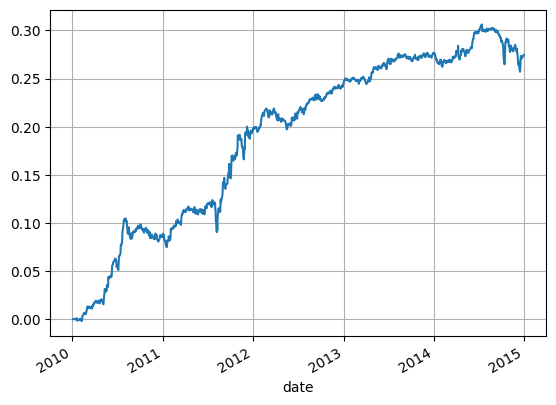

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.085186,0.736884,2.460491,0.024187,04.08.2010,14.12.2010
2011,0.110338,0.798306,2.087095,0.033280,21.07.2011,08.08.2011
2012,0.048312,0.800952,1.871497,0.021803,23.02.2012,17.05.2012
2013,0.032415,0.793495,1.621036,0.008013,12.08.2013,04.10.2013
2014,-0.001630,0.791966,-0.046135,0.049134,14.07.2014,15.12.2014


In [26]:
alpha_stats(data_returns, algh_alpha_rank_over_rank(n=1, data_volume=data_volume, data_close=data_close, data_open=data_open, cut_middle_coef=0, cut_outliers_coef=0, ranking=True, decaying=False))

### corr

In [27]:
#alpha_1 = algh_high_minus_low_over_close(n=15, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False).fillna(0)
#alpha_2 = algh_high_minus_low_over_close_ts_rank(n=5, ts_rank_data=ts_rank_close_20, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0, ranking=False, decaying=True, decay_d=10, decay_k=10).fillna(0)
#alpha_3 = algh_high_minus_low_over_close_ts_rank(n=5, ts_rank_data=ts_rank_returns_20, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0, ranking=False, decaying=False).fillna(0)
#alpha_4 = algh_alpha_high_plus_low_minus_two_close(data_close=data_close, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=True, decay_d=4, decay_k=3).fillna(0)
#alpha_5 = algh_alpha_reversion(n=5, data_close=data_close, cut_middle_coef=0, cut_outliers_coef=0, decaying=False).fillna(0)
#alpha_6 = algh_alpha_rank_over_rank(n=1, data_volume=data_volume, data_close=data_close, data_open=data_open, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False).fillna(0)

In [28]:
#alpha_1.to_csv('../best_alphas/high_minus_low_over_close_n_15.csv')
#alpha_2.to_csv('../best_alphas/algh_high_minus_low_over_close_ts_rankclose20_n_5_cutmid_decay_10.csv')
#alpha_3.to_csv('../best_alphas/algh_high_minus_low_over_close_ts_rankreturns20_n_5_cutmid_.csv')
#alpha_4.to_csv('../best_alphas/algh_alpha_high_plus_low_minus_two_close_decay_4_3.csv')
#alpha_5.to_csv('../best_alphas/algh_alpha_reversion_n_5_.csv')

In [29]:
alpha_1 = pd.read_csv('../best_alphas/high_minus_low_over_close_n_15.csv', index_col='date')
alpha_1.index = alpha_1.index.astype('datetime64')

alpha_2 = pd.read_csv('../best_alphas/algh_high_minus_low_over_close_ts_rankclose20_n_5_cutmid_decay_10.csv', index_col='date')
alpha_2.index = alpha_2.index.astype('datetime64')

alpha_3 = pd.read_csv('../best_alphas/algh_high_minus_low_over_close_ts_rankreturns20_n_5_cutmid_.csv', index_col='date')
alpha_3.index = alpha_3.index.astype('datetime64')

alpha_4 = pd.read_csv('../best_alphas/algh_alpha_high_plus_low_minus_two_close_decay_4_3.csv', index_col='date')
alpha_4.index = alpha_4.index.astype('datetime64')

alpha_5 = pd.read_csv('../best_alphas/algh_alpha_reversion_n_5_.csv', index_col='date')
alpha_5.index = alpha_5.index.astype('datetime64')


In [30]:
pnl_1 = get_pnl(data_returns, alpha_1)
pnl_2 = get_pnl(data_returns, alpha_2)
pnl_3 = get_pnl(data_returns, alpha_3)
pnl_4 = get_pnl(data_returns, alpha_4)
pnl_5 = get_pnl(data_returns, alpha_5)

In [31]:
pnls_matrix = pd.DataFrame()
pnls_matrix['pnl_1'] = pnl_1
pnls_matrix['pnl_2'] = pnl_2
pnls_matrix['pnl_3'] = pnl_3
pnls_matrix['pnl_4'] = pnl_4
pnls_matrix['pnl_5'] = pnl_5
pnls_matrix

,pnl_1,pnl_2,pnl_3,pnl_4,pnl_5
date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.000000,0.000000,0.000000,0.000944,0.000000
2010-01-07,0.000000,0.000000,0.000000,0.003137,0.000000
2010-01-08,0.000000,0.000000,0.000000,0.000999,0.000000
...,...,...,...,...,...
2014-12-24,0.000673,0.001276,0.001785,0.003663,0.003065
2014-12-26,0.000412,-0.000862,0.001475,0.006001,0.001020
2014-12-29,-0.001274,0.001868,0.001282,-0.001963,0.001190


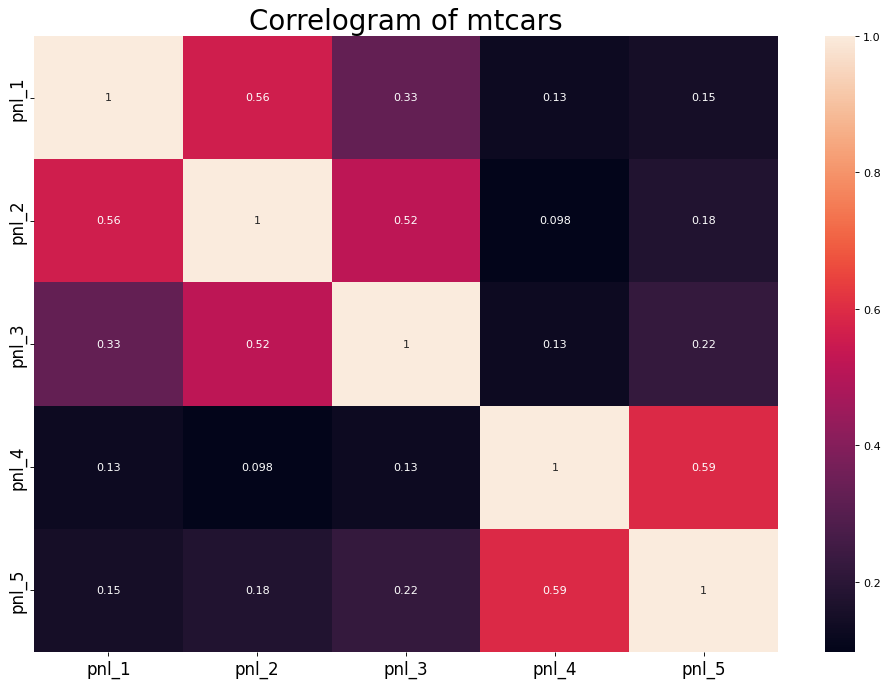

In [32]:
plt.figure(figsize=(15,10), dpi=80)
sns.heatmap(pnls_matrix.corr(), annot=True)
plt.title('Correlogram of mtcars', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Uniform portfolio

In [33]:
portfolio_uniform = ((alpha_1 + alpha_2 + alpha_3 + alpha_4 + alpha_5) / 5).T.apply(normalize).T

0.7631408803728441


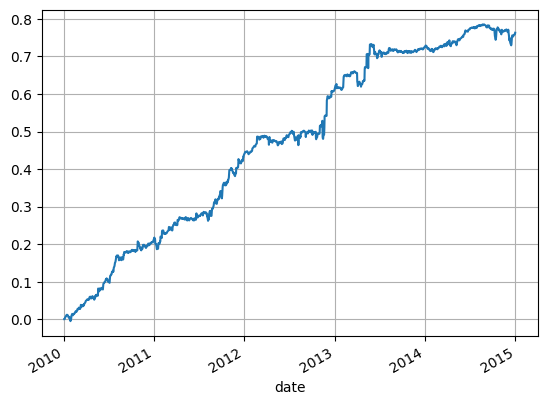

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.210748,0.620404,4.020500,0.023779,28.10.2010,11.11.2010
2011,0.225306,0.610665,3.161276,0.030939,03.01.2011,13.01.2011
2012,0.175284,0.597698,1.749884,0.048141,12.11.2012,15.11.2012
2013,0.113889,0.596984,1.242238,0.040797,22.03.2013,17.04.2013
2014,0.037914,0.563055,0.755179,0.055751,27.08.2014,15.12.2014


In [34]:
alpha_stats(data_returns, portfolio_uniform)

### X ~ sharpe

$$ X_{i}(y) = {sharpe(\alpha_{i}, y-1) \over k(y-1)}$$
$$ k(y) = \sum_{i=1}^{n} sharpe(\alpha_{i}, y) $$

In [35]:
def get_portfolio_sharpe(data_returns, *args):
    years = np.array((data_returns.groupby(data_returns.index.year).size())).cumsum()
    portfolio_sharpe = pd.DataFrame(np.zeros(data_returns.shape))
    portfolio_sharpe.index = data_returns.index
    portfolio_sharpe.columns = data_returns.columns
    portfolio_sharpe.iloc[:years[0]] = (sum(args) / 5).iloc[:years[0]]
    # проход по годам
    for i in range(1, len(years)):
        X = np.zeros(len(args))
        # проход по альфам
        for j in range(len(args)):
            X[j] = get_sharpe_coef(get_pnl(data_returns, args[j])).iloc[i - 1]
            portfolio_sharpe.iloc[years[i - 1] : years[i]] += args[j].iloc[years[i - 1] : years[i]] * X[j]
        portfolio_sharpe.iloc[years[i - 1] : years[i]] /= X.sum()
    return portfolio_sharpe.T.apply(normalize).T

0.7983287345625825


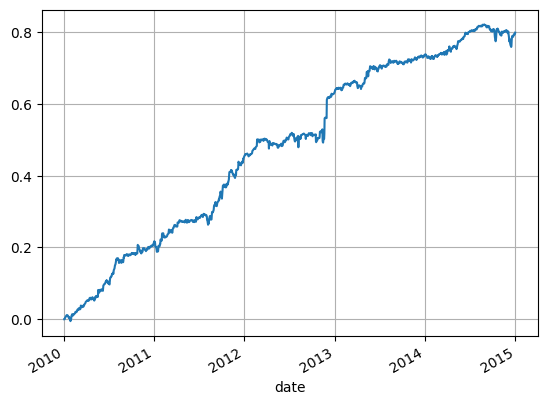

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.210748,0.620404,4.020500,0.023779,28.10.2010,11.11.2010
2011,0.238996,0.676311,3.388169,0.030350,21.07.2011,08.08.2011
2012,0.181766,0.695841,1.766721,0.040196,11.07.2012,07.08.2012
2013,0.105012,0.683906,2.197341,0.022996,22.03.2013,17.04.2013
2014,0.061807,0.672443,1.119106,0.062779,28.08.2014,15.12.2014


In [36]:
alpha_stats(data_returns, get_portfolio_sharpe(data_returns, alpha_1, alpha_2, alpha_3, alpha_4, alpha_5))

### X ~ returns (cumpnl)

$$ X_{i}(y) = {cumPnl(\alpha_{i}, y-1) \over k(y-1)}$$
$$ k(y) = \sum_{i=1}^{n} cumPnl(\alpha_{i}, y) $$

In [37]:
def get_portfolio_cumpnl(data_returns, *args):
    years = np.array((data_returns.groupby(data_returns.index.year).size())).cumsum()
    portfolio_sharpe = pd.DataFrame(np.zeros(data_returns.shape))
    portfolio_sharpe.index = data_returns.index
    portfolio_sharpe.columns = data_returns.columns
    portfolio_sharpe.iloc[:years[0]] = (sum(args) / 5).iloc[:years[0]]
    # проход по годам
    for i in range(1, len(years)):
        X = np.zeros(len(args))
        # проход по альфам
        for j in range(len(args)):
            X[j] = get_pnl(data_returns, args[j], 1).iloc[i - 1]
            portfolio_sharpe.iloc[years[i - 1] : years[i]] += args[j].iloc[years[i - 1] : years[i]] * X[j]
        portfolio_sharpe.iloc[years[i - 1] : years[i]] /= X.sum()
    return portfolio_sharpe.T.apply(normalize).T

0.7462182341579381


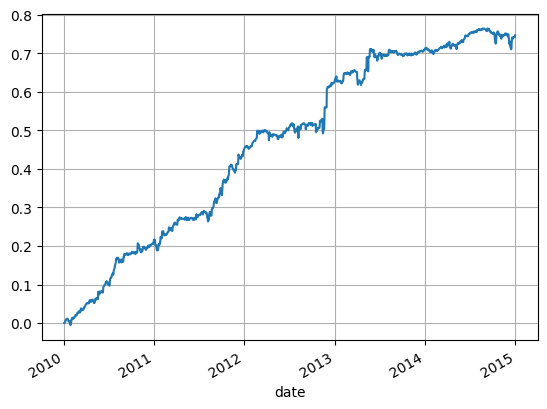

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.210748,0.620404,4.020500,0.023779,28.10.2010,11.11.2010
2011,0.237264,0.669235,3.399510,0.028882,03.01.2011,13.01.2011
2012,0.178153,0.691510,1.781661,0.038617,11.07.2012,07.08.2012
2013,0.084303,0.627854,1.015749,0.038410,22.03.2013,17.04.2013
2014,0.035750,0.551712,0.698864,0.054251,27.08.2014,15.12.2014


In [38]:
alpha_stats(data_returns, get_portfolio_cumpnl(data_returns, alpha_1, alpha_2, alpha_3, alpha_4, alpha_5))

### X ~ sharpe \over corr

In [39]:
alphas = [alpha_1, alpha_2, alpha_3, alpha_4, alpha_5]

In [40]:
def get_portfolio_corr(data_returns, *args):
    years = np.array((data_returns.groupby(data_returns.index.year).size())).cumsum()
    portfolio_corr = pd.DataFrame(np.zeros(data_returns.shape))
    portfolio_corr.index = data_returns.index
    portfolio_corr.columns = data_returns.columns
    portfolio_corr.iloc[:years[0]] = (sum(args) / 5).iloc[:years[0]]
    portfolio_corr.iloc[:years[0]] = portfolio_corr.iloc[:years[0]].T.apply(normalize).T

    X_pnl = pd.DataFrame(np.zeros((data_returns.shape[0], len(args))))
    X_pnl.index = data_returns.index
    # заполняем матрицу pnl для первого года
    X = np.zeros(len(args))
    for j in range(len(args)):
        X_pnl[j].iloc[:years[0]] = np.array(get_pnl(data_returns, args[j]).iloc[:years[0]].fillna(0)).reshape(years[0])
    # проход по годам
    for i in range(1, len(years)):
        X = np.zeros(len(args))
        # проход по альфам
        for j in range(len(args)):
            X[j] = get_sharpe_coef(get_pnl(data_returns, args[j])).iloc[i - 1]
            X_pnl[j].iloc[years[i - 1]:years[i]] = np.array(get_pnl(data_returns, args[j]).iloc[years[i - 1]:years[i]].fillna(0)).reshape(years[i] - years[i - 1])
            if i == 1:
                portfolio_corr.iloc[years[0]:years[1]] += args[j].iloc[years[0]:years[1]] * X[j] / (sum(X_pnl.iloc[:years[0]].corr()[j]) - 1) / 2
            else:
                portfolio_corr.iloc[years[i - 1] : years[i]] += args[j].iloc[years[i - 1] : years[i]] * X[j] / (sum(X_pnl.iloc[years[i - 2]:years[i - 1]].corr()[j]) - 1) / 2
    return portfolio_corr.T.apply(normalize).T

0.8164525344104522


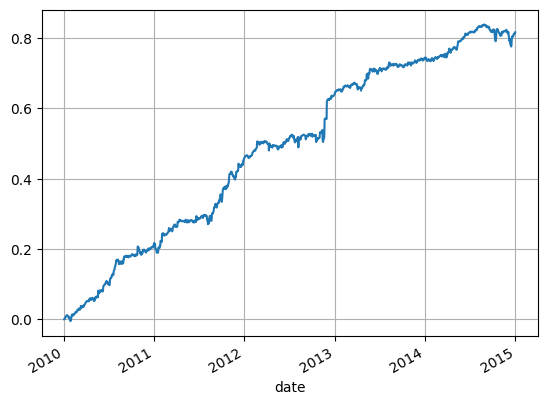

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.210748,0.620404,4.020500,0.023779,28.10.2010,11.11.2010
2011,0.243435,0.666865,3.325308,0.028236,03.01.2011,13.01.2011
2012,0.185434,0.697091,1.886727,0.036410,11.07.2012,07.08.2012
2013,0.104166,0.695387,2.216399,0.022502,22.03.2013,17.04.2013
2014,0.072670,0.763468,1.320917,0.062956,28.08.2014,15.12.2014


In [41]:
alpha_stats(data_returns, get_portfolio_corr(data_returns, alpha_1, alpha_2, alpha_3, alpha_4, alpha_5))